# Introduction

This series of notebooks documents the analysis of microbiomes from various origins. The data were collected from 25 ponds, each belonging to one of five different experimental setups (see table below) that varied in probiotic supplementation.

For each pond, multiple samples were collected:

- Fish gut samples: Five samples from five individual fish.
- Sediment samples: Two samples per pond, collected at two different time points (refer to the sediment notebooks).
- Water samples: Three samples per pond, collected at three time points (refer to the H₂O notebooks).

  

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|



The 16S rRNA region of these samples was sequenced using the Illumina HiSeq 2000 platform. Subsequently, abundance tables for bacterial families, KEGG pathways, and KEGG orthologs were generated using the GGPicrust2 software.

The primary objectives of this analysis are to:

- Compare different approaches to classification analysis of the datasets.
- Develop an effective classification model capable of accurately distinguishing between experimental setups.

If you want to learn more [Here](https://theta.edu.pl/projects/cyprinus_carpio/) you can find describtion of the full project on our website.

# Libraries import and data loading  

If you want you can run this notebook in google colaboratory platfotm using [this link]() 


In [1]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import normalize , LabelEncoder
from sklearn.model_selection import train_test_split, KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.callbacks import EarlyStopping

from functions import *

np.random.seed(111)
tf.random.set_seed(111)

In [2]:
# load data from github 

df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/Gut_analysis/Data/Gut_bacteria_merged.csv')
print(f"shape:{df.shape}")
print(df.dtypes.value_counts())
df.head()

shape:(124, 127)
float64    126
object       1
Name: count, dtype: int64


,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


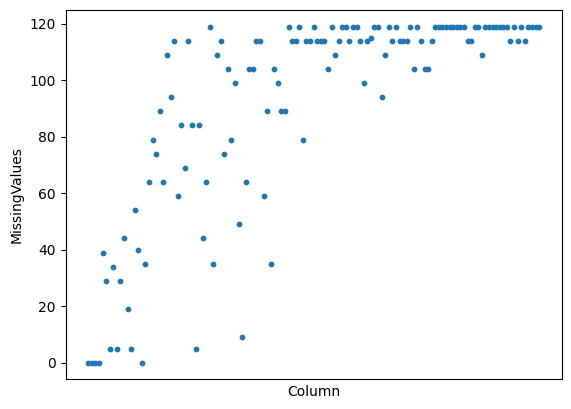

In [3]:


missing_values = df.isna().sum().reset_index()
missing_values.columns = ['Column', 'MissingValues']

# Plotting the number of missing values
ax = missing_values.plot(kind='scatter', x='Column', y='MissingValues', s=10)

# Removing X-axis values
ax.set_xticks([])
plt.show()

We can note that we have a lot of missing values in our dataset this says that samples taken from different ponds are having differrent bacteria famillies, fortunetaly as missing values means that no bacteria of given familly was found we can replace missing values with zeroes.

In [4]:
df = df.fillna(0)
df.head()

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
df.describe()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,831.653226,8693.169355,171.370968,71.137097,105.548387,196.209677,677.419355,375.854839,53.169355,25.241935,...,0.096774,0.298387,0.080645,2.153226,0.217742,1.604839,0.153226,0.096774,0.266129,0.185484
std,1120.105607,5604.123141,224.484829,146.755443,192.490201,637.902078,2845.964849,456.780652,98.483354,67.552253,...,1.077632,2.270274,0.898027,20.938565,2.093585,13.805159,1.706250,1.077632,2.537872,2.065461
min,0.000000,167.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,106.750000,3913.500000,37.750000,0.000000,0.000000,6.750000,0.000000,55.500000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,469.500000,7454.500000,105.500000,2.000000,13.500000,27.500000,0.000000,211.000000,4.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1037.750000,12774.000000,241.000000,91.500000,131.000000,118.250000,48.750000,467.250000,62.250000,15.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,6597.000000,26160.000000,1743.000000,1054.000000,1024.000000,5020.000000,23193.000000,2505.000000,581.000000,539.000000,...,12.000000,23.000000,10.000000,232.000000,23.000000,144.000000,19.000000,12.000000,28.000000,23.000000


After seeing some basic statistics regarding columns we can see that range of valueus varries a lot we should normalise collumns (features).
We should also perform conversion of class variable to assign samples from different ponds to class used later for training of the model.

### Conversion of class variable


Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [6]:
predictors = df.columns[1:]
print(f"Number of predictors: {len(predictors)}")

Number of predictors: 126


In [6]:
df.head()

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,Gut_S10,2319.0,2187.0,1743.0,500.0,521.0,286.0,366.0,612.0,160.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Gut_S10,3391.0,2071.0,355.0,1054.0,1024.0,1952.0,66.0,217.0,95.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Gut_S10,1338.0,7053.0,669.0,279.0,329.0,63.0,52.0,1338.0,139.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Gut_S10,1582.0,15595.0,124.0,503.0,309.0,5.0,3418.0,326.0,76.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Gut_S10,1463.0,3891.0,541.0,7.0,13.0,11.0,61.0,398.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
# creating dataset splitted into 5 classes based on the pond 
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

df['pond_5'] = df['pond'].apply(lambda x: pond_decoder(x,codes))

In [9]:
df['pond_5'].value_counts()

pond_5
2    25
4    25
1    25
3    25
0    24
Name: count, dtype: int64

## Normalization 
In the next step we will normalize predictor variables for that we will use standard scaler. During our testing normalisation proved to have better results than not normalised dataset.

In [10]:
df[predictors] = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)

In [11]:
df.describe()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae,pond_5
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,0.126065,0.332308,0.098320,0.067493,0.103075,0.039086,0.029208,0.150042,0.091514,0.046831,...,0.012973,0.008065,0.009281,0.009467,0.011145,0.008065,0.008065,0.009505,0.008065,2.016129
std,0.169790,0.214225,0.128792,0.139237,0.187979,0.127072,0.122708,0.182348,0.169507,0.125329,...,0.098708,0.089803,0.090252,0.091025,0.095869,0.089803,0.089803,0.090638,0.089803,1.414121
min,0.000000,0.006384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016182,0.149599,0.021658,0.000000,0.000000,0.001345,0.000000,0.022156,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.071169,0.284958,0.060528,0.001898,0.013184,0.005478,0.000000,0.084232,0.006885,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
75%,0.157306,0.488303,0.138267,0.086812,0.127930,0.023556,0.002102,0.186527,0.107143,0.028293,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


Here we can see results of normalisation as each feature is getting values in the same range (0:1). This helps model to treat each feature equaly regardless of its overall abundance. There is an argument against normalisation as more abundant bacteria should have more impact but normalisation proved to help with results.

## Splitting data into train and test sets


In [14]:
df_train_val, df_test = train_test_split(df, test_size=0.2, random_state=111, stratify=df['pond_5'], shuffle=True)
df_train_val.shape, df_test.shape

((99, 128), (25, 128))

At this point we have data ready for modeling with test size 20% of data, having 126 columns of bacteria abduance as predictor variables 99 reads as train set) and experimental setup as target varaible (1 column) with 5 classes we made sure that there is good representation of classes in each of datasets. In the next step we perform crossvalidation on our model.

# Model building, compiling, crossvalidating

Initial strategy as we have not much data is to have some more dropout to prevent overfitting and lower learning rate as well as more epochs to compensate for dropout.
- For loss function we will use [caterogical crossentropy](https://keras.io/api/losses/probabilistic_losses/#categoricalcrossentropy-class) as we have several encoded categories
- For metrics we will use [accuracy](https://keras.io/api/metrics/accuracy_metrics/) as it works well with our integer mutliclass predictor variable
- For optimizer we will chose Adam as it is an usual choice [optimzier choosing](https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e) we will set small learning rate at beggining but it might be that our network will rapidly stop learning becouse of that, in that case it is neccesary to update learning rate to bigger number


WE'd like to also introduce Confidence Score which is metric calculated by dividing the highest probability from the class probabilities vector returned by neural network by sum of rest of probabilities, it dedfines how much model is "sure" of its decisions and how we think is a nice addition to training statistics as it can help with defining robustness of the model.

In [19]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)

## model building and compiling
the following model is result of many trial and error atempts to create best classifier.  
 model with 2 hidedn layers with relu as an activation function. we have no values below zero/one so relu is predicting practically lineary but it is giving best results as sigmoid is too agresive and loss function is varring by a lot during training ("jumping"), also two dropout layers to prevent overfitting and one output layer with softmax activation function.

In [15]:
model1 = keras.Sequential()
model1.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(5, activation ='softmax'))

model1.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,637 (100.14 KB)

 Trainable params: 25,637 (100.14 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
loss = "categorical_crossentropy"
metrics = ["accuracy"]
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)
model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## Crossvalidation


Number of classes: 5
training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.6000 - loss: 0.9219
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
predicted classes:       [1 3 4 2 4 3 0 1 3 1 1 4 2 4 1 2 4 3 4 2]
true validation classes: [3 3 1 2 2 0 1 1 3 1 1 4 2 4 0 2 4 1 3 2]
mean confidence score: 161148.5753, sd confidence score: 702295.9196
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5000 - loss: 1.4032
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
predicted classes:       [4 1 1 2 4 1 2 2 3 3 1 3 2 4 1 2 3 0 4 1]
true validation classes: [0 0 0 2 4 0 0 2 3 0 1 3 4 4 0 2 3 1 2 1]
mean confidence score: 1404.6249, sd confidence score: 5233.951
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4000 - loss: 1.5328
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
predicted classes:       [3 1 4 2 4 4 0 0 0 0 0 3 2 4 2 3 3 2 4 0]
true validation classes: [1 1 2 2 0 4 0 3 0 4 3 1 4 2 2 1 3 1 4 1]
mean confidence score: 176034744630.729, sd con

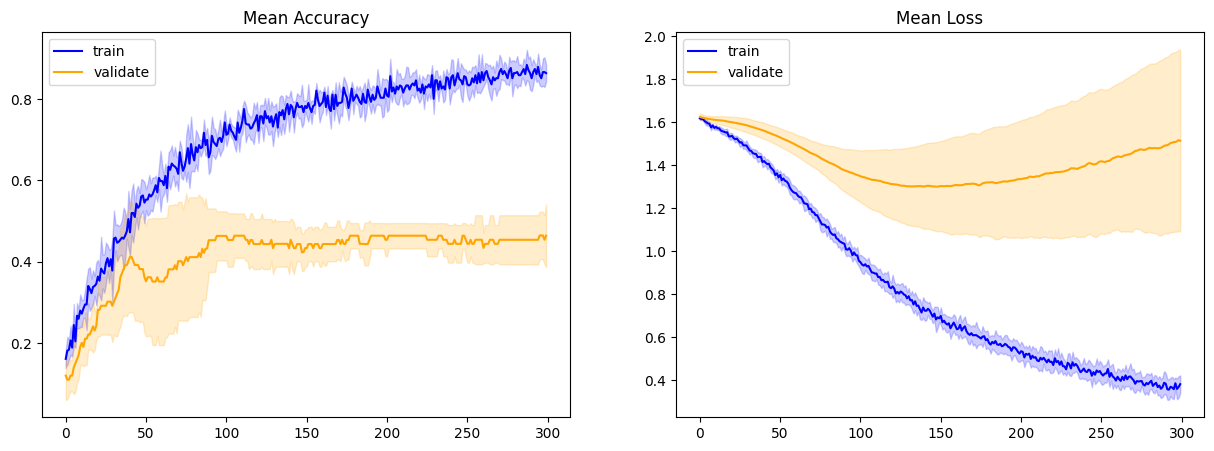

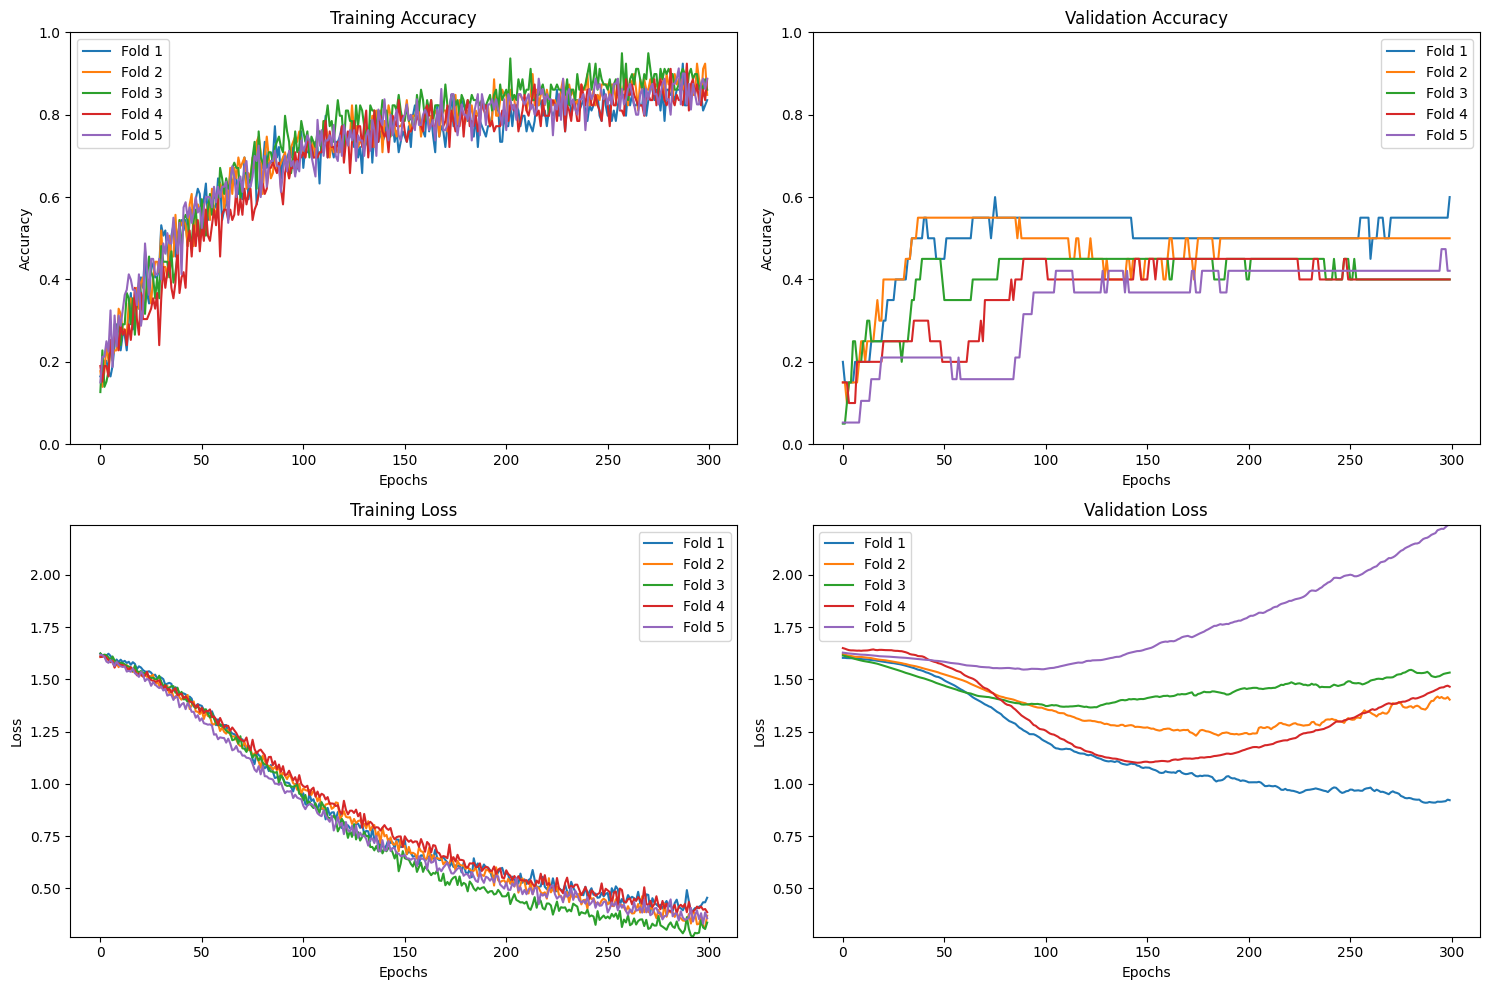

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
predicted classes:       [4 0 1 2 1 0 0 0 4 2 0 4 4 1 3 0 4 1 3]
true validation classes: [4 0 4 2 2 0 3 1 2 0 2 4 4 3 3 4 1 0 3]


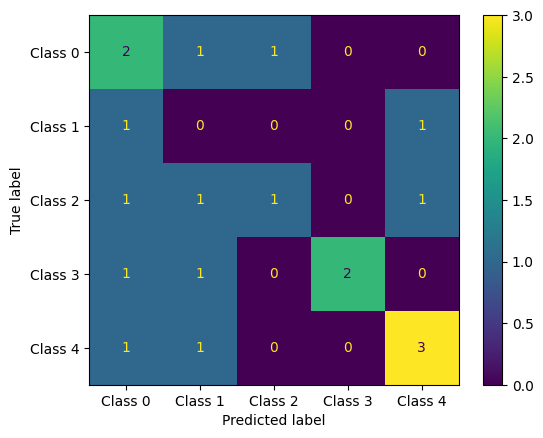

In [23]:
crossvalidate(df_train_val, model1, predictors, 'pond_5', kf)

In [ ]:
evaluate_model(model1, history, X_test, y_test, acc_name = "Accuracy", loss_name = "Loss"):


In [19]:

history1=model1.fit(df_train_val[predictors], y_train, epochs = 500, verbose = 1, shuffle = True, validation_data=(X_test, y_test))


Epoch 1/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.1887 - loss: 1.6262 - val_accuracy: 0.1316 - val_loss: 1.6203
Epoch 2/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.1927 - loss: 1.6285 - val_accuracy: 0.1316 - val_loss: 1.6196
Epoch 3/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2664 - loss: 1.6317 - val_accuracy: 0.1053 - val_loss: 1.6188
Epoch 4/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.1964 - loss: 1.6209 - val_accuracy: 0.1053 - val_loss: 1.6181
Epoch 5/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.1653 - loss: 1.6215 - val_accuracy: 0.1053 - val_loss: 1.6175
Epoch 6/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2043 - loss: 1.6200 - val_accuracy: 0.1053 - val_loss: 1.6168
Epoch 7/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2995 - loss: 1.6047 - val_accuracy: 0.1053 - val_loss: 1.6161
Epoch 8/500
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2004 - loss: 1.6216 - val_accuracy: 0.1053 - val_loss:

# model evaluation
After training our data its time to evaluate model
we will start by extracting predicted classes from our predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4265 - loss: 1.1665 
[1.166693091392517, 0.42105263471603394]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[4 4 2 3 2 1 4 4 2 3 2 4 2 4 0 3 1 3 3 4 1 2 1 1 4 0 0 3 1 1 1 1 4 4 4 2 1
 2]
[4 0 2 3 2 0 4 2 4 3 2 3 1 2 0 3 0 4 1 4 0 4 3 1 4 0 1 1 0 3 1 4 1 2 1 2 3
 2]


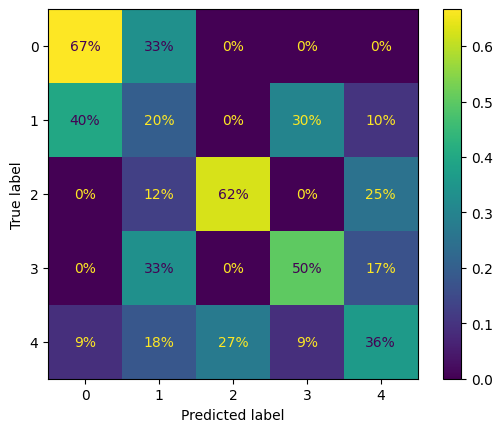

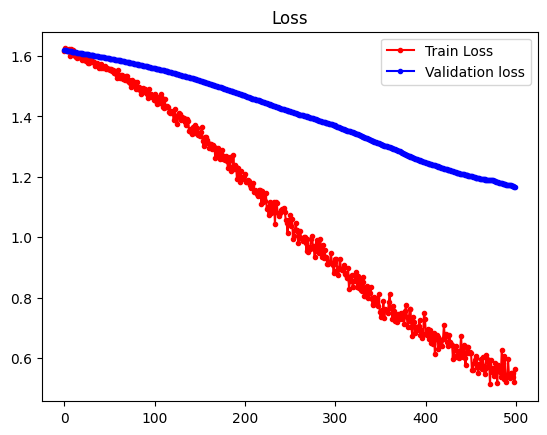

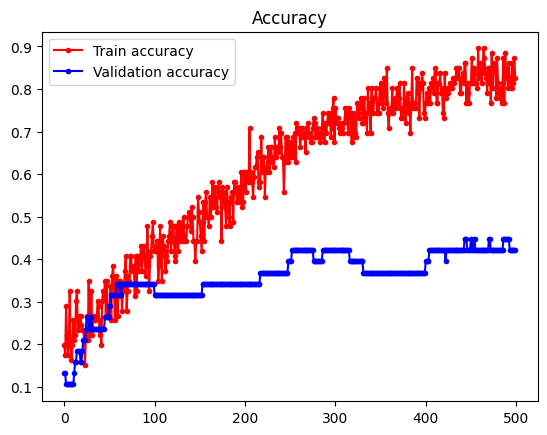

In [20]:
# here we are using function from beggining but you can find more desrcribed below
evaluate_model(model1, history1, X_test, y_test)

In [21]:
y_pred = model1.predict(X_test)

print(y_pred[:1])
# we need to convert those to classes 
y_pred_class = y_pred.argmax(axis=1)
print(y_pred_class[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
[[0.11972294 0.20629543 0.0834676  0.14966968 0.44084442]]
4


In [22]:
# just to check how the output looks like we have to also convert our original test values
print("predicted classes: ",y_pred_class[:3])
print(y_test[:3])
y_test_classes = y_test.argmax(axis=1)
print("True classes: ",y_test_classes[:3])

predicted classes:  [4 4 2]
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]]
True classes:  [4 0 2]


In [23]:
# here its just evaluation on train and test set (same as if we looked at end of history of training)
print(model1.evaluate(X_train,y_train))
print(model1.evaluate(X_test,y_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8969 - loss: 0.4772 
[0.46751224994659424, 0.895348846912384]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.4265 - loss: 1.1665  
[1.166693091392517, 0.42105263471603394]


## Accuraacy and Loss function plots

In [24]:
history1.history.keys() 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

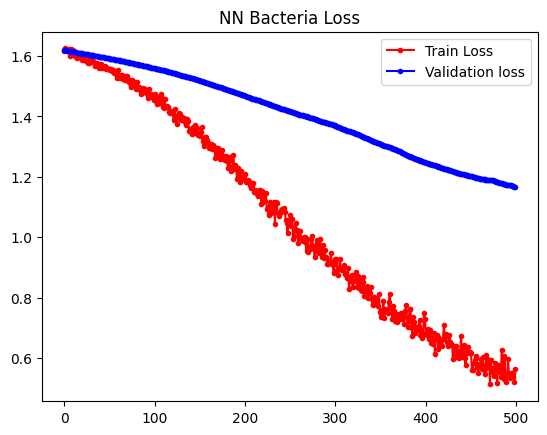

In [25]:
title = "DNN_Gut_loss"
fig, ax = plt.subplots()
ax.plot(history1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(history1.history["val_loss"],'b', marker='.', label="Validation loss")
plt.title("NN Bacteria Loss")
ax.legend()
#plt.savefig(title+'.png')

Text(0.5, 1.0, 'NN Bacteria Acc')

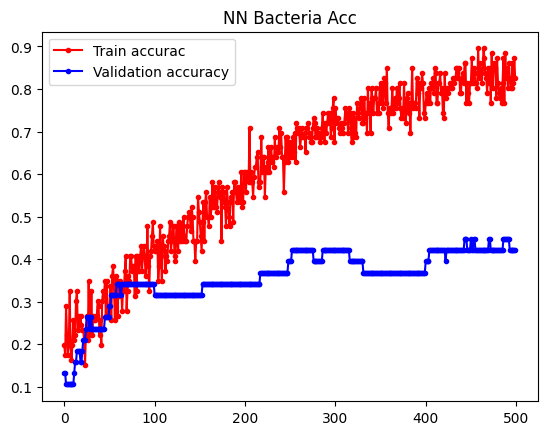

In [26]:
fig, ax = plt.subplots()
title = "DNN_Gut_acc"
ax.plot(history1.history["accuracy"],'r', marker='.', label="Train accurac")
ax.plot(history1.history["val_accuracy"],'b', marker='.', label="Validation accuracy")
ax.legend()
plt.title("NN Bacteria Acc")
#plt.savefig(title+'.png')

On this plots we can see that model reached peak accuracy for validation dataset of around 0.6 after around 280 epochs and then accuracy started to drop, similar conclusions we can draw from loss function plot where we can see overfitting to data near 350 epochs. 

## Probability ploting
We also want to see how sure model is of its predictions so we will plot highest probabity of belonging to classes

We can see here that model is not "sure" of its decisions in most of the cases. 

## Confusion matrix
We created confusion matrix to acces quality of the model and its predictions we can easily see using this tool what classes are most difficult to recognize by the model

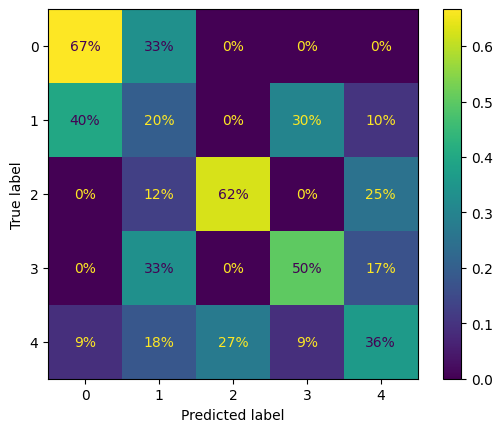

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay
y_test_class = y_test.argmax(axis = 1)
sample_weight=(y_pred_class != y_test_class )
plt.rc('font',size = 10)
ConfusionMatrixDisplay.from_predictions(y_pred_class,y_test_class, #sample_weight = sample_weight,
                                        normalize = "true", values_format = ".0%")


Explanation of pond coding

| number | setup | pond numbers | water supplementation | feed suplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

So as we can see model is confusing setup 1 with 3, 0 and vice versa, similar case to 2 and 4. the reason for this is feed suplementation similarities between those setups. We could draw conclusions that feed supplementation has much more impact on microbiome than water supplementation.  With this knowledge we will divide data into  categories and see if results improve.

# 3 classes
Here we will divide dataset into 3 classes 
0 - control (no water or feed suplementation)
1 - no feed suplementation 
2 - feed suplementation

In [28]:
#creting decoder we will change our decoder to divide into 3 classes

def pond_decoder(x,codes):
    x=x.replace('S','')
    num = int(x.split("_")[1])
    
    
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   
    
#pond_decoder("gut_14")

In [29]:
#performing change of target variable collumn 
codes = {0 : [8,14,18,24,29], 1: [12,16,19,23,26,9,13,17,20,27], 2 : [10,21,28,30,32,11,15,22,25,31]}


df_3['pond'] = df_3['pond'].apply(lambda x: pond_decoder(x,codes))


In [30]:
df_3['pond'] = df_3['pond'].astype('category')

In [31]:
df_3.head()
df_3.describe()
df_3['pond'].unique()

[2, 1, 0]
Categories (3, int64): [0, 1, 2]

## target and predictor variables set creation and normalization 
we will normalize predictor variables we will normalise by dividing each value in row by maximum value of that row. We want to get rid of variance between samples thats why we normalise by rows not by collumns. We will also convert labels to one hot encoding ones.

In [32]:
target = ['pond']
predictors = list(set(list(df_3.columns)) - set(target))
#print(predictors)

In [33]:
#normalisation by collumns best for now 
df_3[predictors]=df_3[predictors]/df_3[predictors].max()

#normalisation by rows 
#df_3[predictors] = df_3[predictors].apply(lambda row: row / row.max(axis=0), axis=0)

#normalisation using sklearn 
#df_3[predictors] = normalize(df_3[predictors], norm='max', axis=0, copy=True, return_norm=False)


In [34]:
#replacing 0 values with small value 
#df_3[predictors] = df_3[predictors].replace(0,0.00001)


In [35]:
df_3

,pond,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
0,2,0.351523,0.083601,1.000000,0.474383,0.508789,0.056972,0.015781,0.244311,0.275387,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.514022,0.079167,0.203672,1.000000,1.000000,0.388845,0.002846,0.086627,0.163511,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.202819,0.269610,0.383821,0.264706,0.321289,0.012550,0.002242,0.534132,0.239243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,0.239806,0.596139,0.071142,0.477230,0.301758,0.000996,0.147372,0.130140,0.130809,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0.221767,0.148739,0.310384,0.006641,0.012695,0.002191,0.002630,0.158882,0.006885,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119,1,0.015765,0.376988,0.061388,0.018975,0.007812,0.016534,0.000129,0.036727,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
120,1,0.113688,0.133142,0.242111,0.361480,0.239258,0.023705,0.362739,0.162874,0.051635,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
121,1,0.027740,0.043616,0.076879,0.189753,0.102539,0.002191,0.559393,0.049501,0.077453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
122,1,0.074276,0.006384,0.004590,0.081594,0.048828,0.000398,1.000000,0.026347,0.027539,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Splitting data into train and test sets


In [36]:
X3=df_3[predictors].values
y3=df_3[target].values
yt3 = keras.utils.to_categorical(y3, 3)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,yt3,test_size=0.3,random_state=111,stratify = yt,shuffle = True)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)


(86, 126) (38, 126) (86, 5) (38, 5)


At this point we have data ready for modeling with test size 30% of data, having 126 columns of bacteria abduance as predictor variables 86 reads as train set) and experimental setup as target varaible ( 1 column) with 3 classes we made sure that there is good representation of classes in each of datasets, we will use test dataset for validation during training as we dont have enought data and validation set does not 

## model building and compiling


In [37]:
model3 = keras.Sequential()


model3.add(keras.layers.Dense(128,input_shape=(X_train.shape[1],),activation='relu'))


model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(64, activation ='relu'))
model3.add(keras.layers.Dropout(rate=0.25))
model3.add(keras.layers.Dense(16, activation ='relu'))

model3.add(keras.layers.Dense(3, activation ='softmax'))

model3.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,603 (100.01 KB)

 Trainable params: 25,603 (100.01 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
# worth trying same loss as metrics
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model3.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## model fiting 


In [40]:

history3=model3.fit(X_train3, y_train3, epochs = 750, verbose = 1, shuffle = True, validation_data=(X_test3, y_test3))


Epoch 1/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.1731 - loss: 1.1559 - val_accuracy: 0.1842 - val_loss: 1.1395
Epoch 2/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1984 - loss: 1.1414 - val_accuracy: 0.1842 - val_loss: 1.1368
Epoch 3/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2121 - loss: 1.1395 - val_accuracy: 0.1842 - val_loss: 1.1345
Epoch 4/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2159 - loss: 1.1409 - val_accuracy: 0.1842 - val_loss: 1.1322
Epoch 5/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2257 - loss: 1.1409 - val_accuracy: 0.1842 - val_loss: 1.1299
Epoch 6/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2336 - loss: 1.1294 - val_accuracy: 0.1842 - val_loss: 1.1277
Epoch 7/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2101 - loss: 1.1341 - val_accuracy: 0.1842 - val_loss: 1.1254
Epoch 8/750
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2315 - loss: 1.1325 - val_accuracy: 0.1842 - val_loss:

## model evaluation

In [41]:
model3.predict(X_test3)[:4]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


array([[1.70980860e-02, 1.86786372e-02, 9.64223206e-01],
       [4.41206545e-01, 1.16000855e-02, 5.47193348e-01],
       [2.69978656e-04, 1.68424449e-05, 9.99713242e-01],
       [1.19079202e-02, 9.78419960e-01, 9.67210997e-03]], dtype=float32)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6853 - loss: 0.7639
[0.7751049995422363, 0.6842105388641357]
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
[2 2 2 1 2 1 2 2 2 1 2 1 2 2 2 1 2 1 1 2 2 2 1 1 2 0 1 1 1 1 0 1 2 2 2 2 1
 2]
[2 0 2 1 2 0 2 2 2 1 2 1 1 2 0 1 0 2 1 2 0 2 1 1 2 0 1 1 0 1 1 2 1 2 1 2 1
 2]


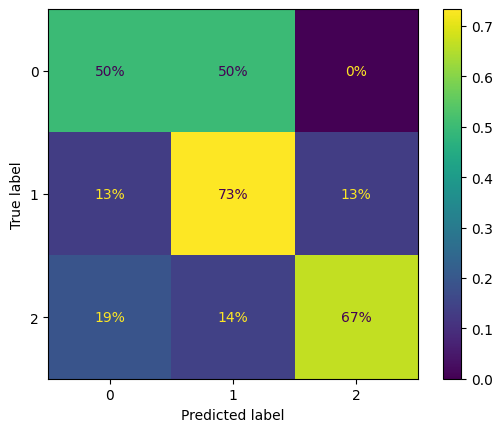

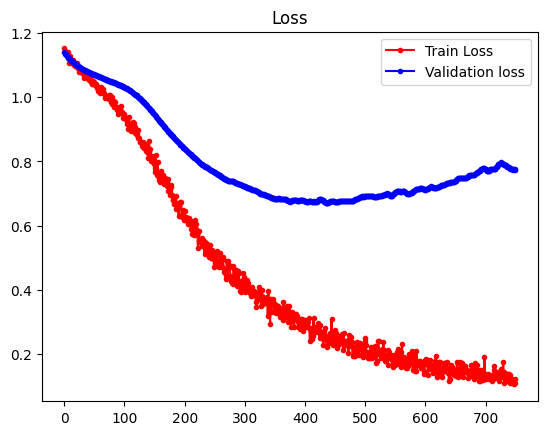

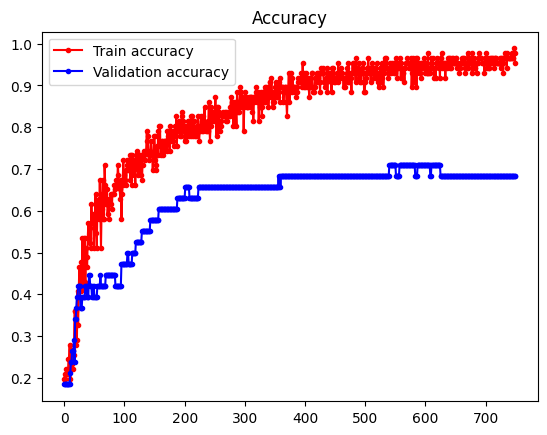

In [42]:
evaluate_model(history = history3, model = model3, X_test = X_test3, y_test = y_test3)

Here we will plot probablity belonging some class for each sample to see how "sure" model is of its decisions.

To remind ourselves what classes look like 

| number | class | pond numbers | feed suplementation |
|---|---|---|---|
|0|control(0) | 8,14,18,24,29|NO|
|1|1|12,16,19,23,26,9,13,17,20,27|NO|
|2|2| 10,21,28,30,32,11,15,22,25,31|EM|


As we can see this did help a bit, accuracy rised to around 0.7 (70% of predictions were matches). Looking at confusion matrix the results for 1 and 2 class are good problem is with controll class, although it is understandable why model is confusing control with 1 class based on conclusions we draw before that feed suplementation has much more impact it is weird that model is misstaking 0 class as 2 class. We might try binary classification approach based only on feed suplementation without control group. 

# 2 classes
As we mentioned later here we will focus only on 2 classes 
- 0 - no feed classification 
- 1 - feed suplementation 

In [43]:
#performing change of target variable collumn 
codes = {0 : [8,14,18,24,29,12,16,19,23,26,9,13,17,20,27], 1 : [10,21,28,30,32,11,15,22,25,31]}

df_2['pond'] = df_2['pond'].apply(lambda x: pond_decoder(x,codes))


In [44]:
df_2['pond'] = df_2['pond'].astype('category')

In [45]:
df_2.head()
df_2.describe()
df_2['pond'].unique()

[1, 0]
Categories (2, int64): [0, 1]

## target and predictor variables set creation and normalization 
we will normalize predictor variables we will normalise by dividing each value in row by maximum value of that row. We want to get rid of variance between samples thats why we normalise by rows not by collumns. We will also convert labels to one hot encoding ones.

In [46]:
target = ['pond']
predictors = list(set(list(df_2.columns)) - set(target))
#print(predictors)

In [47]:
# normalisation options - use one

#normalisation by collumns best for now 
df_2[predictors]=df_2[predictors]/df_2[predictors].max()

#normalisation by rows 
#df_2[predictors] = df_2[predictors].apply(lambda row: row / row.max(axis=0), axis=0)

#normalisation using sklearn 
#df_2[predictors] = normalize(df_2[predictors], norm='max', axis=0, copy=True, return_norm=False)


In [48]:
#replacing 0 values with small value 
#df_2[predictors] = df_2[predictors].replace(0,0.00001)


In [49]:
df_2.describe()

,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelotrichaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Aeromonadales;f__Aeromonadaceae,d__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Enterococcaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Yersiniaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;__;__,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae,d__Bacteria;p__Fusobacteriota;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Dysgonomonadaceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,...,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Alteromonadales;f__Alteromonadaceae,d__Bacteria;p__Acidobacteriota;c__Vicinamibacteria;o__Vicinamibacterales;f__uncultured,d__Bacteria;p__Verrucomicrobiota;c__Verrucomicrobiae;o__Pedosphaerales;f__Pedosphaeraceae,d__Bacteria;p__Firmicutes;c__Negativicutes;o__Veillonellales-Selenomonadales;f__Sporomusaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Alcaligenaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Vibrionales;f__Vibrionaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pseudomonadales;f__Moraxellaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Flavobacteriales;f__Crocinitomicaceae,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Arcobacteraceae,d__Bacteria;p__Actinobacteriota;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae
count,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,...,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000,124.000000
mean,0.126065,0.332308,0.098320,0.067493,0.103075,0.039086,0.029208,0.150042,0.091514,0.046831,...,0.008065,0.012973,0.008065,0.009281,0.009467,0.011145,0.008065,0.008065,0.009505,0.008065
std,0.169790,0.214225,0.128792,0.139237,0.187979,0.127072,0.122708,0.182348,0.169507,0.125329,...,0.089803,0.098708,0.089803,0.090252,0.091025,0.095869,0.089803,0.089803,0.090638,0.089803
min,0.000000,0.006384,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.016182,0.149599,0.021658,0.000000,0.000000,0.001345,0.000000,0.022156,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.071169,0.284958,0.060528,0.001898,0.013184,0.005478,0.000000,0.084232,0.006885,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.157306,0.488303,0.138267,0.086812,0.127930,0.023556,0.002102,0.186527,0.107143,0.028293,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Splitting data into train and test sets


In [50]:
X2=df_2[predictors].values
y2=df_2[target].values
yt2 = keras.utils.to_categorical(y2, 2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2,yt2,test_size=0.3,random_state=111,stratify = yt,shuffle = True)
print(X_train2.shape,X_test2.shape,y_train2.shape,y_test2.shape)


(86, 126) (38, 126) (86, 2) (38, 2)


In [51]:
y_train2[:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])

## model building and compiling

In [52]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(128,input_shape=(X_train.shape[1],),activation='relu'))


#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
#model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(2, activation ='softmax'))

model2.summary()

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │        16,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,586 (99.95 KB)

 Trainable params: 25,586 (99.95 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]
# worth trying same loss as metrics
optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

## model fiting 


In [55]:

history2=model2.fit(X_train2, y_train2, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test2, y_test2))


Epoch 1/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4105 - loss: 0.6971 - val_accuracy: 0.6579 - val_loss: 0.6870
Epoch 2/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4707 - loss: 0.6939 - val_accuracy: 0.6579 - val_loss: 0.6862
Epoch 3/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5525 - loss: 0.6921 - val_accuracy: 0.6842 - val_loss: 0.6854
Epoch 4/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5797 - loss: 0.6915 - val_accuracy: 0.6579 - val_loss: 0.6846
Epoch 5/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6479 - loss: 0.6844 - val_accuracy: 0.6579 - val_loss: 0.6839
Epoch 6/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6536 - loss: 0.6874 - val_accuracy: 0.7105 - val_loss: 0.6832
Epoch 7/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6927 - loss: 0.6797 - val_accuracy: 0.6842 - val_loss: 0.6825
Epoch 8/300
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6750 - loss: 0.6819 - val_accuracy: 0.6842 - val_loss:

: 

## model evaluation

In [ ]:
evaluate_model(history = history2, model = model2, X_test = X_test2, y_test = y_test2)

To remind ourselves what the current classes look like 

| number | class | pond numbers | feed suplementation |
|---|---|---|---|
|0|0|8,14,18,24,29,12,16,19,23,26,9,13,17,20,27|NO|
|1|1| 10,21,28,30,32,11,15,22,25,31|YES|

We can see much higher accuracy of the model -  0.9, overfitting is still a problem and it is starting even sooner at 300 epochs. But results are good 
Now as we know how the loss curve is looking like we will now try to implement early stopping callback so we can stop the model at the right point (in that peak 0.9 accuracy) as well as callback to save weights so we dont lose our progress

In [ ]:
# for reproductibility purposes we will set random seed 
keras.utils.set_random_seed(333)

In [ ]:
model2 = keras.Sequential()


model2.add(keras.layers.Dense(128,input_shape=(X_train.shape[1],),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='relu'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='relu'))

model2.add(keras.layers.Dense(2, activation ='softmax'))

model2.summary()

In [ ]:
checkpoint_path = "NN_gut_2class/checkpoint"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(patience = 5)

In [ ]:
loss = "categorical_crossentropy"
#loss = "sparse_categorical_crossentropy"
metrics = "accuracy"
# worth trying same loss as metrics
optimizer = keras.optimizers.Adam(learning_rate = 0.0005)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [ ]:
# we create callback here to use tensorboard later on 
import os
logdir = os.path.join("tensorboard_logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1)

history2_2=model2.fit(X_train2, y_train2, epochs = 300, verbose = 1, shuffle = True, validation_data=(X_test2, y_test2),callbacks = [tb_callback,cp_callback,es_callback])


In [ ]:
y_pred = model2.predict(X_test2)
y_pred_class = y_pred.argmax(axis=1)

In [ ]:
evaluate_model(model2, history2_2, X_test2, y_test2)

Here we will test tensorboard another usefull evaluation tool thats what for we needed tensorboard callback created earlier this proved to work best on colaboratory platform 

In [ ]:
%load_ext tensorboard

In [ ]:

%tensorboard --logdir tensorboard_logs --port 6008

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances


In the next notebook we will introduce crossvalidation and test our models to get summary of how models performe using different normalisation methods, some data transformation. Later we will calculate Importance of features for best model. Later we will use different datasets in similar way.